In [1]:
import datetime
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from keras import layers
from keras import models
from keras import regularizers
from keras import utils
from keras.utils import to_categorical
from sklearn.dummy import DummyClassifier
# to run validation on multiple metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.models import save_model


%matplotlib inline

# Preparation Steps

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# encoded tokens
preprocessed_corpus_path_TF = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF.p')

preprocessed_corpus_path_TF_oh = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF_oh.p')

# Define Parameter Dictionary

This dictionary contains all the parameters necessary for the model training. It is going to be saved with the trained model in order to log it. 


Inputs before running a new experiment: 
1. Define experiment name
2. Define model architecture and hyperparameters

In [3]:
logging = True

saving = True

PARAMS = {

    # Define experiment name:
    'experiment_name': 'all_models_no_counter_overfitting',

    # List of models
    'model_type': ['bow', 'fc_emb', 'fc_transf', 'lstm', 'lstm_transf', 'conv1d', 'conv1d_transf'],

    # Parameters general:
    'number_of_classes': len(np.unique(train_descr['Sentiment'])),
    'n_splits': 4,
    'seed': 42,
    'batch_size': 32,  # [16, 32, 64],
    'epochs': 15,
    'hidden_units': 32,  # [16, 32, 64],

    # NLP Parameters
    # max_words = vocabulary size = our samples - number of most frequent words.
    # I set it to 10.000, although in this case there are less.
    # I do this to parametise the code.
    # Aleternatively, I can set it to the length of our vocabulary = word_index
    'max_words': 10000,

    # embedding_size = embedding dimensionality
    'embedding_size': 30,  # [10, 20, 30, 100],

    # Parameters for pre-trained word embeddings:
    'embedding_dim': 100,

    # Parameters for the Conv1D:
    'conv_window': 5,  # [3, 5, 7],

    # Cross-fold validation:
    'k': 4,

    # Regularisation types
    'reg_mode': ['l2', 'dropout', 'combi']
}

logdir = f'logs/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")
logdir_tb = f'logs/tensorboard/experiments/{PARAMS["experiment_name"]}_' + \
    datetime.datetime.now().strftime("%Y_%m_%d-%H:%M")

# create logging folder and tensorboard callback function
if logging:
    print(f'Log results to {logdir}')
    if not os.path.exists(logdir):
        os.makedirs(logdir)

    tensorboard_callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir_tb)]

else:
    logdir = ''
    logdir_tb = ''
    tensorboard_callbacks = []

Log results to logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52


# Load Tokens and Vocabulary

In [4]:
def load_data(path_to_corpus, one_hot=False):
    if not one_hot:
        sequences, word_index = pd.read_pickle(path_to_corpus)

        # max_len = sequence length - the text is cut off after this number of words
        # in this case it is defined as the maximum sequence length in our list of tokenised sequences
        max_len = np.max([len(x) for x in sequences])
        data = tf.keras.preprocessing.sequence.pad_sequences(
            sequences, maxlen=max_len)
    else:
        sequences, word_index = pd.read_pickle(path_to_corpus)
        data = sequences

    labels = train_descr.loc[:, 'Sentiment'].to_list()

    return sequences, word_index, data, labels

for bag-of-words with one-hot encoded tokens

In [5]:
sequences_oh, word_index_oh, data_oh, labels_oh = load_data(
    preprocessed_corpus_path_TF_oh, one_hot=True)
sequences_oh.shape

(6364, 10000)

for the models with embedding layer

In [6]:
sequences, word_index, data, labels = load_data(preprocessed_corpus_path_TF)
print(f'Shape of sequences after padding is {data.shape}')

Shape of sequences after padding is (6364, 25)


Add max_len to parameters dictionary

In [7]:
max_len = np.max([len(x) for x in sequences])
PARAMS['max_len'] = max_len

# Preparation for the Pre-Trained Embeddings

In [8]:
glove_dir = './glove.6B'

In [9]:
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
embedding_matrix = np.zeros((PARAMS['max_words']+1, PARAMS['embedding_dim']))

for word, i in word_index.items():
    if i < PARAMS['max_words']:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(10001, 100)


# Train-Test Split

In [11]:
def train_test_split(data, labels):
    dimensions_labels = PARAMS['number_of_classes']

    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)

    data = data[indices]
    labels = np.asarray(labels)
    labels = labels[indices]

    training_samples = int(0.8 * len(data))

    x_train = data[:training_samples]
    y_train = labels[:training_samples]

    x_test = data[training_samples:]
    y_test = labels[training_samples:]

    y_train_oh = tf.one_hot(indices=y_train, depth=dimensions_labels)
    y_train_oh = np.asarray(y_train_oh)

    y_test_oh = tf.one_hot(indices=y_test, depth=dimensions_labels)
    y_test_oh = np.asarray(y_test_oh)

    return x_train, y_train_oh, x_test, y_test_oh

In [12]:
x_train, y_train, x_test, y_test = train_test_split(data, labels)

x_train_oh, y_train_oh, x_test_oh, y_test_oh = train_test_split(
    data_oh, labels_oh)

# Oversample the Minority Classes

In [13]:
def oversample_smote(x_train, y_train):
    oversample = SMOTE()
    x_train, y_train = oversample.fit_resample(x_train, y_train)

    return x_train, y_train


def plot_classes(y_train):
    counter = Counter(y_train)
    for k, v in counter.items():
        per = v / len(y_train) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    plt.bar(counter.keys(), counter.values())
    plt.show()

# Generate a Model

In [14]:
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

In [15]:
def generate_model(model_type, params_dict):
    """
    This function compiles a model according to the chosen model_type
    Args: 
        - model_type - which model type is to be used
        - params_dict - dictionary with parameters for the model

    Returns: 
        - a compiled model
    """

    # set parameters
    hidden_units = params_dict['hidden_units']
    dimensions_labels = params_dict['number_of_classes']
    max_words = params_dict['max_words']
    max_len = params_dict['max_len']
    embedding_size = params_dict['embedding_size']
    embedding_dim = params_dict['embedding_dim']
    conv_window = params_dict['conv_window']

    # fully connected bag-of-words
    if model_type == params_dict['model_type'][0]:
        model = models.Sequential()
        model.add(layers.Dense(hidden_units, activation='relu',
                               input_shape=(max_words, )))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # fully connected & "homegrown" embeddings layer
    elif model_type == params_dict['model_type'][1]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_size, input_length=max_len))
        model.add(layers.Flatten())
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # fully connected & a pre-trained embeddings layer
    elif model_type == params_dict['model_type'][2]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.Flatten())
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    # lstm with "homegrowm" embeddings layer
    elif model_type == params_dict['model_type'][3]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.LSTM(hidden_units))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # lstm with pre-trained embeddings layer
    elif model_type == params_dict['model_type'][4]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))
        model.add(layers.LSTM(hidden_units))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(hidden_units, activation='relu'))
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights(
            [embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    # conv1D with "homegrown" embeddings layer
    elif model_type == params_dict['model_type'][5]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_size, input_length=max_len))

        model.add(layers.Conv1D(
            hidden_units,  # features to be extracted
            conv_window,  # convolutional window size
            activation='relu',
        ))
        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

    # conv1D with pre-trained embeddings layer
    elif model_type == params_dict['model_type'][6]:
        model = models.Sequential()
        model.add(layers.Embedding(max_words+1,
                                   embedding_dim, input_length=max_len))

        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu',))
        model.add(layers.Conv1D(hidden_units, conv_window, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(dimensions_labels, activation='softmax'))

        model.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
        model.layers[0].trainable = False

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model

# Training with Cross-Validation (incl. Upsampling)

* Due to the small data quantity, cross-validation will be used to train the models.
* Furthermore, as the classes are imbalanced, an oversampling will be introduced. ! It is important to generate the training and validation sets BEFORE the upsampling. Otherwise the exact same observations could be present in both the train and validation sets, i.e. data leakage would occur. This can allow the model to simply memorize specific data points and cause overfitting and poor generalization on unseen data. 
* The oversampling will be applied only on the train set in order to ensure that the model generalises well on unseen data (validation set and ultimately test set)

In [16]:
def train_with_cross_val(k, model, model_type, train_data, train_labels, epochs, batch_size, reg_mode=None, reg=False):
    """
    This function applies a k-fold cross-validation and saves the model history per fold & epoch.
    Args: 
        - k - number of folds
        - model - compiled model
        - model_type - which model type is to be used
        - train_data - the tokenised, padded and shuffled sequences
        - train_labels - labels 
        - epochs - number of epochs
        - batch_size - batch size
    """
    num_val_samples = len(train_data) // k

    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
        val_labels = train_labels[i *
                                  num_val_samples:(i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)

        partial_train_labels = np.concatenate(
            [train_labels[:i * num_val_samples],
             train_labels[(i + 1) * num_val_samples:]],
            axis=0
        )

        partial_train_data_ovs, partial_train_labels_ovs = oversample_smote(
            partial_train_data, partial_train_labels)

        history = model.fit(
            partial_train_data_ovs, partial_train_labels_ovs,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(val_data, val_labels),
            # callbacks=tensorboard_callbacks
        )

        if reg == False:
            np.save(f'history_{model_type}_fold_{i}.npy', history.history)

        else:
            np.save(
                f'history_{model_type}_{reg_mode}_fold_{i}.npy', history.history)

    if saving:
        if reg:
            path = os.path.join(logdir, f'{model_type}')
            model.save(path)
        else:
            path = os.path.join(logdir, f'{model_type}_{reg_mode}')
            model.save(path)

# Baseline Model

Idea Model: https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html


* As the Fully Connected NN model's the precision, recall and f1 are calculcated unweighted, precision, recall & f1 are chosen to be macro
* According to the sklearn-documentation this method calculates the metrics for each label, and finds their unweighted mean and does not take label imbalance into account.
* Example documentation for precision: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

Note: test_[metric] is validation and therefore comparable to the val_[metric] of the model.

In [17]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [18]:
model_base = DummyClassifier(strategy='most_frequent')

In [19]:
cv = KFold(n_splits=PARAMS['k'], random_state=PARAMS['seed'])

scores = cross_validate(
    model_base, x_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [20]:
for metric, score in scores.items():
    print(f'Mean {metric}: %.3f (%.3f)' %
          (np.mean(score), np.std(score)))

Mean fit_time: 0.002 (0.001)
Mean score_time: 0.016 (0.005)
Mean test_accuracy: 0.589 (0.014)
Mean test_precision_macro: 0.147 (0.003)
Mean test_recall_macro: 0.250 (0.000)
Mean test_f1_macro: 0.185 (0.003)


# Train the Model per Type

In [21]:
for model_type in PARAMS['model_type']:
    model = generate_model(model_type, PARAMS)

    if model_type == PARAMS['model_type'][0]:
        train_with_cross_val(PARAMS['k'], model, model_type, x_train_oh,
                             y_train_oh, PARAMS['epochs'], PARAMS['batch_size'])
    else:
        train_with_cross_val(
            PARAMS['k'], model, model_type, x_train, y_train, PARAMS['epochs'], PARAMS['batch_size'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 321,220
Trainable params: 321,220
Non-trainable params: 0
_________________________________________________________________
processing fold # 0


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/bow_None/assets
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 30)            300030    
_________________________________________________________________
flatten (Flatten)            (None, 750)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                24032     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_______________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/fc_emb_None/assets
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 132       
Total params: 1,081,320
Trainable params: 81,220
Non-trainable params: 1,000,100
_________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/fc_transf_None/assets
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 132       
Total params: 1,019,368
Trainable params: 1,019,368
Non-trainable params: 0
___________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/lstm_None/assets
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 132       
Total params: 1,019,368
Trainable params: 19,268
Non-trainable params: 1,000,100
___________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/lstm_transf_None/assets
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 30)            300030    
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 32)            4832      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 32)            5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 132       
Total params: 310,146
Trainable params: 310,146
Non-trainable params: 0
_____________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/conv1d_None/assets
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 32)            16032     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 17, 32)            5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 132       
Total params: 1,021,416
Trainable params: 21,316
Non-trainable params: 1,000,100
_________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/conv1d_transf_None/assets


# Evaluate the Models

### Generate a Metrics Dataframe

In [22]:
history_all_df = pd.DataFrame()

for model_type in PARAMS['model_type']:
    for i in range(PARAMS['k']):
        history = np.load(
            f'history_{model_type}_fold_{i}.npy', allow_pickle='TRUE').item()
        history['model_type'] = model_type

        history_df = pd.DataFrame(history)

        history_df['f1'] = 2 * history_df.precision * \
            history_df.recall/(history_df.precision + history_df.recall)
        history_df['f1'] = history_df['f1'].fillna(0)
        history_df['val_f1'] = 2 * history_df.val_precision * \
            history_df.val_recall / \
            (history_df.val_precision + history_df.val_recall)
        history_df['val_f1'] = history_df['val_f1'].fillna(0)

        history_all_df = history_all_df.append(history_df)

history_all_df
history_all_df_pivot = history_all_df.pivot_table(columns=['model_type'],
                                                  values=['loss', 'val_loss', 'accuracy', 'val_accuracy', 'precision', 'val_precision', 'f1', 'val_f1'])

In [23]:
history_all_df

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,model_type,f1,val_f1
0,0.702180,0.738980,0.875577,0.506790,0.889611,0.629717,0.649603,0.578616,bow,0.641991,0.612058
1,0.246158,0.905499,0.910535,0.899488,0.970661,0.639151,0.652068,0.632075,bow,0.904978,0.641916
2,0.159991,0.939225,0.941150,0.938112,1.115557,0.629717,0.637530,0.625000,bow,0.939629,0.631203
3,0.121288,0.952248,0.952853,0.951581,1.265974,0.617138,0.619730,0.612421,bow,0.952217,0.616054
4,0.096759,0.962934,0.963140,0.962712,1.373973,0.639151,0.640985,0.634434,bow,0.962926,0.637693
...,...,...,...,...,...,...,...,...,...,...,...
10,0.256796,0.925000,0.942717,0.903683,0.854086,0.703616,0.726062,0.685535,conv1d_transf,0.922788,0.705216
11,0.226447,0.938504,0.951886,0.920759,0.891479,0.702830,0.725539,0.687893,conv1d_transf,0.936064,0.706215
12,0.200047,0.945871,0.959546,0.934487,0.917029,0.705975,0.727727,0.687107,conv1d_transf,0.946851,0.706834
13,0.179608,0.954687,0.965490,0.942969,0.907116,0.718553,0.736020,0.703616,conv1d_transf,0.954096,0.719453


In [24]:
history_all_df_pivot

model_type,bow,conv1d,conv1d_transf,fc_emb,fc_transf,lstm,lstm_transf
accuracy,0.978634,0.923544,0.801535,0.941980,0.822101,0.899644,0.669725
f1,0.977022,0.915225,0.783190,0.935727,0.807084,0.889157,0.630150
loss,0.056043,0.219138,0.531709,0.147622,0.436340,0.249598,0.742521
precision,0.981114,0.940612,0.847665,0.957639,0.877677,0.923801,0.743615
val_accuracy,0.856407,0.784211,0.662893,0.818003,0.669785,0.756591,0.714112
val_f1,0.855984,0.779017,0.653388,0.814580,0.665783,0.752414,0.703015
val_loss,0.548852,0.851144,0.932344,0.699801,1.165412,1.214381,0.751077
val_precision,0.857659,0.799473,0.701183,0.827654,0.707492,0.770252,0.755922


### Pick the 2 models with the highest F1-score

* All of the models outperform the baseline model in all the metrics
* The models before regularisation with the best F1-score are the bag-of-words and the "homegrown" embeddings
* These two models will be optimised further and used for the final multi-input model

In [25]:
history_all_df_pivot.idxmax(axis=1)

accuracy                 bow
f1                       bow
loss             lstm_transf
precision                bow
val_accuracy             bow
val_f1                   bow
val_loss                lstm
val_precision            bow
dtype: object

In [26]:
history_all_df_pivot.loc['val_f1', ].max()

0.8559842149536

### Generate Summary Figures

In [27]:
history_all_grouped = history_all_df.groupby('model_type').mean()
history_all_grouped = history_all_grouped.reset_index()
history_all_grouped

,model_type,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,f1,val_f1
0,bow,0.056043,0.978634,0.981114,0.974570,0.548852,0.856407,0.857659,0.854389,0.977022,0.855984
1,conv1d,0.219138,0.923544,0.940612,0.900875,0.851144,0.784211,0.799473,0.763614,0.915225,0.779017
2,conv1d_transf,0.531709,0.801535,0.847665,0.738740,0.932344,0.662893,0.701183,0.616313,0.783190,0.653388
3,fc_emb,0.147622,0.941980,0.957639,0.923857,0.699801,0.818003,0.827654,0.806184,0.935727,0.814580
4,fc_transf,0.436340,0.822101,0.877677,0.758666,1.165412,0.669785,0.707492,0.633582,0.807084,0.665783
5,lstm,0.249598,0.899644,0.923801,0.867944,1.214381,0.756591,0.770252,0.738221,0.889157,0.752414
6,lstm_transf,0.742521,0.669725,0.743615,0.555976,0.751077,0.714112,0.755922,0.662277,0.630150,0.703015


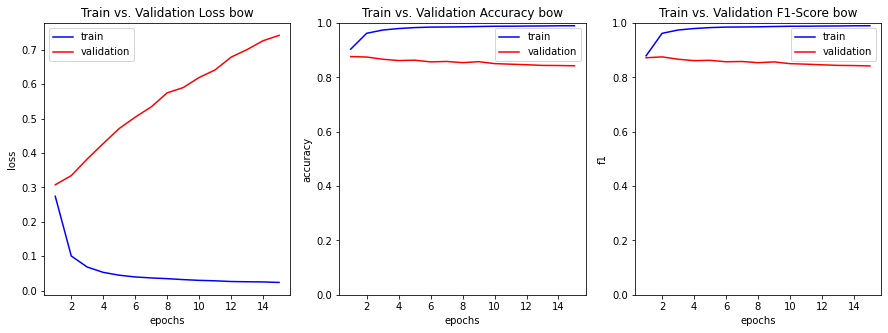

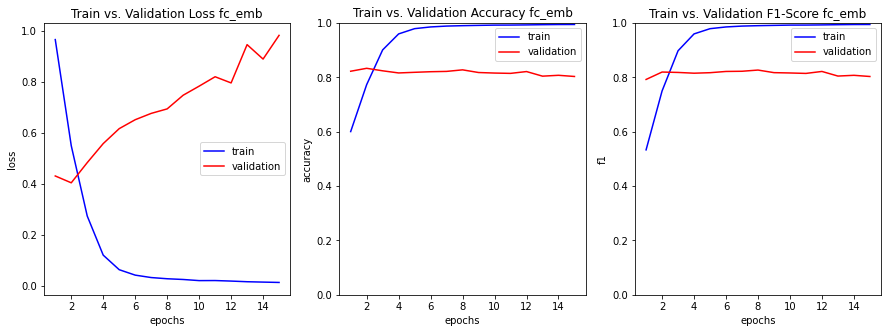

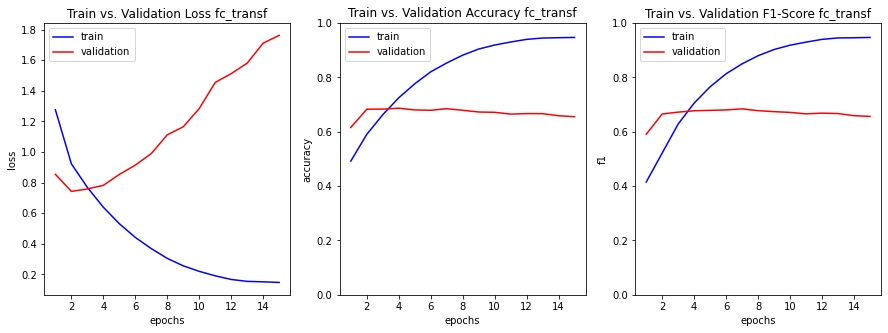

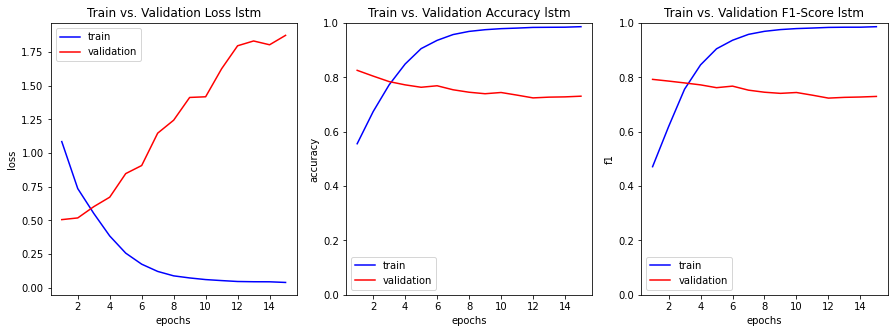

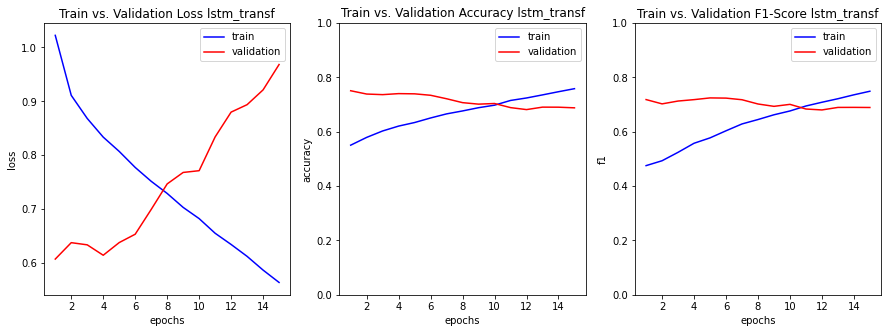

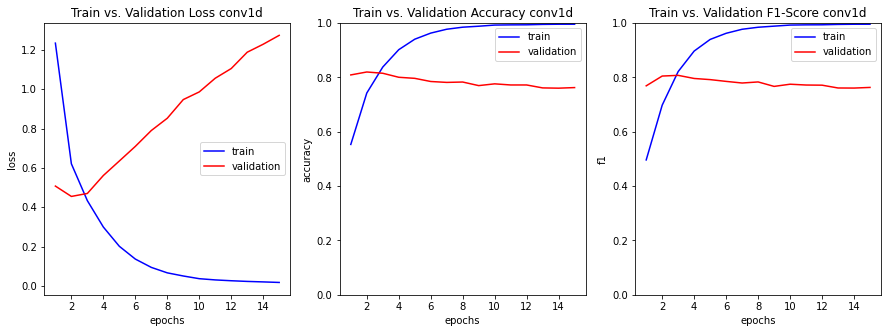

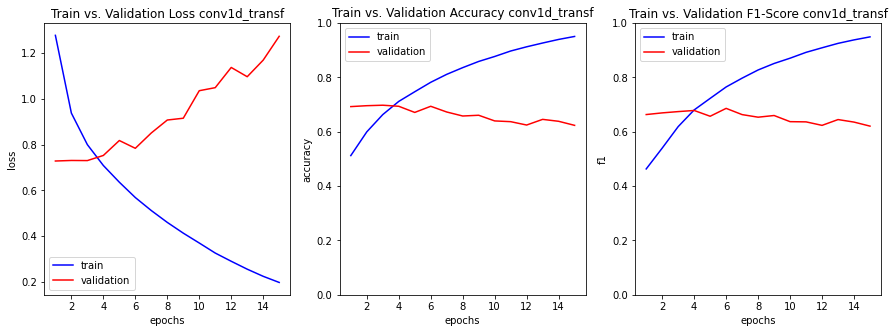

In [28]:
for model_type in PARAMS['model_type']:
    fig = plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)

    epochs = PARAMS['epochs']
    epochs_graph = range(1, PARAMS['epochs'] + 1)
    folds = PARAMS['k']

    mask = history_all_df.loc[:, 'model_type'] == model_type

    loss_all = history_all_df.loc[mask, 'loss'].to_list()
    loss_prep = [loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
    loss = [np.mean([x[i] for x in loss_prep]) for i in range(epochs)]

    val_loss_all = history_all_df.loc[mask, 'val_loss'].to_list()
    val_loss_prep = [
        val_loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
    val_loss = [np.mean([x[i] for x in val_loss_prep]) for i in range(epochs)]

    accuracy_all = history_all_df.loc[mask, 'accuracy'].to_list()
    accuracy_prep = [
        accuracy_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
    accuracy = [np.mean([x[i] for x in accuracy_prep]) for i in range(epochs)]

    val_accuracy_all = history_all_df.loc[mask, 'val_accuracy'].to_list()
    val_accuracy_prep = [val_accuracy_all[i *
                                          epochs:(i + 1) * epochs] for i in range(folds)]
    val_accuracy = [np.mean([x[i] for x in val_accuracy_prep])
                    for i in range(epochs)]

    f1_all = history_all_df.loc[mask, 'f1'].to_list()
    f1_prep = [f1_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
    f1 = [np.mean([x[i] for x in f1_prep]) for i in range(epochs)]

    val_f1_all = history_all_df.loc[mask, 'val_f1'].to_list()
    val_f1_prep = [val_f1_all[i * epochs:(i + 1) * epochs]
                   for i in range(folds)]
    val_f1 = [np.mean([x[i] for x in val_f1_prep]) for i in range(epochs)]

    plt.plot(epochs_graph, loss, 'b')
    plt.plot(epochs_graph, val_loss, 'r')
    plt.ylim([0, 2])
    ax.set_ylabel('loss')
    ax.set_xlabel('epochs')
    ax.legend(['train', 'validation'])
    plt.title(f'Train vs. Validation Loss {model_type}')

    ax = plt.subplot(132)
    plt.plot(epochs_graph, accuracy, 'b')
    plt.plot(epochs_graph, val_accuracy, 'r')
    plt.ylim([0, 1])
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epochs')
    ax.legend(['train', 'validation'])
    plt.title(f'Train vs. Validation Accuracy {model_type}')

    ax = plt.subplot(133)
    plt.plot(epochs_graph, f1, 'b')
    plt.plot(epochs_graph, val_f1, 'r')
    plt.ylim([0, 1])
    ax.set_ylabel('f1')
    ax.set_xlabel('epochs')
    ax.legend(['train', 'validation'])
    plt.title(f'Train vs. Validation F1-Score {model_type}')

    if logging:
        if not os.path.exists(os.path.join(logdir, 'figures')):
            os.makedirs(os.path.join(logdir, 'figures'))
        fig.savefig(os.path.join(
            logdir, f'figures/loss_accuracy_training_{model_type}.png'), bbox_inches='tight')

# Regularization

* Two models were found, which have very good performance on the training data, i.e. they are very well optimised. 
* With this the goal to find the best performance on the training data was achieved. 
* However, as a result they overfit, i.e. they do not perform well on data they have never seen before. The wide gap between loss vs. validation loss on the graphs above is an indicator of this. 
* Now, the models should be adjusted to perform well also on unseen data, i.e. to generalise better. 
* Several possibilites to do that - more data and / or modulate the quantity of information that the model is allowed to store or to add constraints on what information it’s allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.
* The latter is called regularisation and this is what will be applied, as there is no additional data available. 
* Regularisation can be achieved by reducing the capacity of the model, adding weight regularisation or introducing dropout
* As both models are not that complex, their capacity will not be reduced
* Weights regularisation, Dropout & their combination will be tested

In [47]:
def generate_model_reg(model_type, params_dict, reg_mode):
    """
    This function compiles a model according to the chosen model_type
    Args: 
        - model_type - which model type is to be used
        - params_dict - dictionary with parameters for the model

    Returns: 
        - a compiled model
    """

    # set parameters
    hidden_units = params_dict['hidden_units']
    dimensions_labels = params_dict['number_of_classes']
    max_words = params_dict['max_words']
    max_len = params_dict['max_len']
    embedding_size = params_dict['embedding_size']
    embedding_dim = params_dict['embedding_dim']
    conv_window = params_dict['conv_window']

    if reg_mode == 'l2':
        # every coefficient in the weight matrix of the layer will add regularisation factor * weight_coefficient_value
        # to the total loss of the network
        # the default value for the regularisation factor is 0.01
        # Keras documentation: https://keras.io/api/layers/regularizers/

        # fully connected bag-of-words
        if model_type == params_dict['model_type'][0]:
            model = models.Sequential()
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu',
                                   input_shape=(max_words, )))
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

        # fully connected & "homegrown" embeddings layer
        elif model_type == params_dict['model_type'][1]:
            model = models.Sequential()
            model.add(layers.Embedding(max_words+1,
                                       embedding_size, input_length=max_len))
            model.add(layers.Flatten())
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

    elif reg_mode == 'dropout':
        # rate: what percentage of the input units to drop
        # Keras documentation: https://keras.io/api/layers/regularization_layers/dropout/

        # fully connected bag-of-words
        if model_type == params_dict['model_type'][0]:
            model = models.Sequential()
            model.add(layers.Dense(hidden_units, activation='relu',
                                   input_shape=(max_words, )))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(hidden_units, activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

        # fully connected & "homegrown" embeddings layer
        elif model_type == params_dict['model_type'][1]:
            model = models.Sequential()
            model.add(layers.Embedding(max_words+1,
                                       embedding_size, input_length=max_len))
            model.add(layers.Flatten())
            model.add(layers.Dense(hidden_units, activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(hidden_units, activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

    elif reg_mode == 'combi':
        # fully connected bag-of-words
        if model_type == params_dict['model_type'][0]:
            model = models.Sequential()
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu',
                                   input_shape=(max_words, )))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

        # fully connected & "homegrown" embeddings layer
        elif model_type == params_dict['model_type'][1]:
            model = models.Sequential()
            model.add(layers.Embedding(max_words+1,
                                       embedding_size, input_length=max_len))
            model.add(layers.Flatten())
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(hidden_units,
                                   kernel_regularizer=regularizers.l2(),
                                   activation='relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(dimensions_labels, activation='softmax'))

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=metrics
    )

    return model

### Weight Regularisation

**Explanation of regularisation as given in "Deep Learning with Python" by Chollet:** "You may be familiar with the principle of Occam’s razor: given two explanations for something, the explanation most likely to be correct is the simplest one - the one that makes fewer assumptions. This idea also applies to the models learned by neural net- works: given some training data and a network architecture, multiple sets of weight values (multiple models) could explain the data. Simpler models are less likely to overfit than complex ones.
A simple model in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters, as you saw in the previous section). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to take only small values, which makes the distribution of weight values more regular. This is called weight regularization, and it’s done by adding to the loss function of the network a cost associated with having large weights. "

### Dropout

**Explanation of dropout as given in "Deep Learning with Python" by Chollet:** "...Dropout, applied to a layer, consists of randomly dropping out (setting to zero) a number of output features of the layer during training. Let’s say a given layer would normally return a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training. After applying dropout, this vector will have a few zero entries distributed at random: for example, [0, 0.5, 1.3, 0, 1.1]. The dropout rate is the fraction of the features that are zeroed out; it’s usually set between 0.2 and 0.5. At test time, no units are dropped out; instead, the layer’s output values are scaled down by a factor equal to the dropout rate, to balance for the fact that more units are active than at training time. 

...was inspired by, among other things, a fraud-prevention mecha- nism used by banks. In his own words, “I went to my bank. The tellers kept changing and I asked one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting.” The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that aren’t significant (what Hinton refers to as conspiracies), which the network will start memorizing if no noise is present.
"

In [48]:
for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        model = generate_model_reg(model_type, PARAMS, reg_mode)

        if model_type == PARAMS['model_type'][0]:
            train_with_cross_val(PARAMS['k'], model, model_type, x_train_oh,
                                 y_train_oh, PARAMS['epochs'], PARAMS['batch_size'], reg_mode, reg=True)
        else:
            train_with_cross_val(
                PARAMS['k'], model, model_type, x_train, y_train, PARAMS['epochs'], PARAMS['batch_size'], reg_mode, reg=True)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_36 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 132       
Total params: 321,220
Trainable params: 321,220
Non-trainable params: 0
_________________________________________________________________
processing fold # 0


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/bow/assets
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 32)                320032    
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 132       
Total params: 321,220
Trainable params: 321,220
Non-trainable params: 0
_________________________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/bow/assets
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 32)                320032    
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 132       
Total params: 321,220
Trainable params: 321,220
Non-trainable params: 0
_________________________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/bow/assets
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 25, 30)            300030    
_________________________________________________________________
flatten_5 (Flatten)          (None, 750)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 32)                24032     
_________________________________________________________________
dense_45 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 132       
Total params: 325,250
Trainable params: 325,250
Non-trainable params: 0
_________________________________________________________________

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/fc_emb/assets
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 25, 30)            300030    
_________________________________________________________________
flatten_6 (Flatten)          (None, 750)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 32)                24032     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
__

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/fc_emb/assets
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 25, 30)            300030    
_________________________________________________________________
flatten_7 (Flatten)          (None, 750)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 32)                24032     
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
__

/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 1


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 2


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


processing fold # 3


/Users/iskriyanavasileva/opt/anaconda3/envs/nlp-sent/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


INFO:tensorflow:Assets written to: logs/experiments/all_models_no_counter_overfitting_2020_12_11-12:52/fc_emb/assets


In [49]:
history_all_df_reg = pd.DataFrame()

for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        for i in range(PARAMS['k']):
            history = np.load(
                f'history_{model_type}_{reg_mode}_fold_{i}.npy', allow_pickle='TRUE').item()
            history['model_type'] = model_type
            history['reg_mode'] = reg_mode

            history_df_reg = pd.DataFrame(history)

            history_df_reg['f1'] = 2 * history_df.precision * \
                history_df.recall / \
                (history_df_reg.precision + history_df_reg.recall)
            history_df_reg['f1'] = history_df_reg['f1'].fillna(0)
            history_df_reg['val_f1'] = 2 * history_df_reg.val_precision * \
                history_df_reg.val_recall / \
                (history_df_reg.val_precision + history_df_reg.val_recall)
            history_df_reg['val_f1'] = history_df_reg['val_f1'].fillna(0)

            history_all_df_reg = history_all_df_reg.append(history_df_reg)

history_all_df_reg
history_all_df_pivot_reg = history_all_df_reg.pivot_table(columns=['model_type', 'reg_mode'],
                                                          values=['loss', 'val_loss', 'accuracy', 'val_accuracy', 'precision', 'val_precision', 'f1', 'val_f1'])

In [50]:
history_all_df_pivot_reg

model_type          bow                        fc_emb                    
reg_mode          combi   dropout        l2     combi   dropout        l2
accuracy       0.807410  0.941266  0.913661  0.672141  0.836051  0.897745
f1             0.885185  0.749577  0.774238  1.102669  0.839385  0.789870
loss           0.709179  0.160262  0.441382  0.812690  0.391865  0.402679
precision      0.849205  0.949987  0.927206  0.768609  0.894125  0.918896
val_accuracy   0.585653  0.851520  0.641431  0.738378  0.797235  0.762592
val_f1         0.547760  0.849006  0.631323  0.721578  0.789622  0.754594
val_loss       1.172321  0.487978  1.111152  0.869550  0.824265  0.907966
val_precision  0.602655  0.854807  0.655966  0.782191  0.818763  0.780192

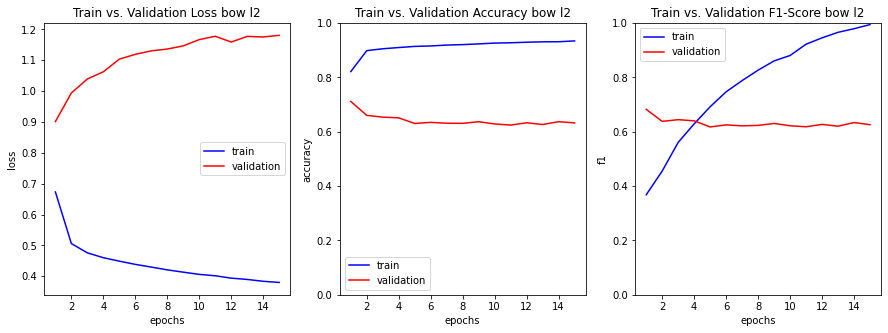

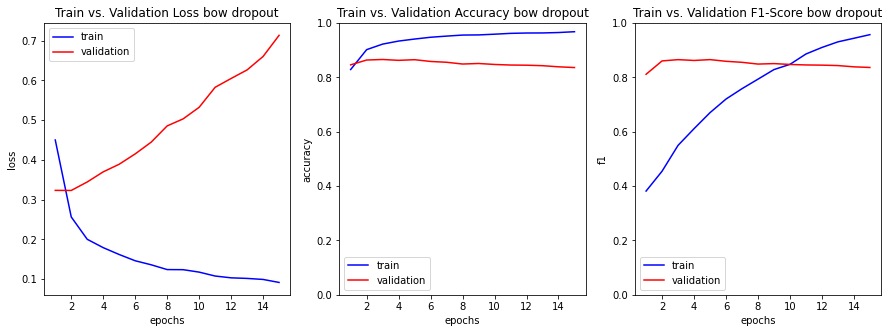

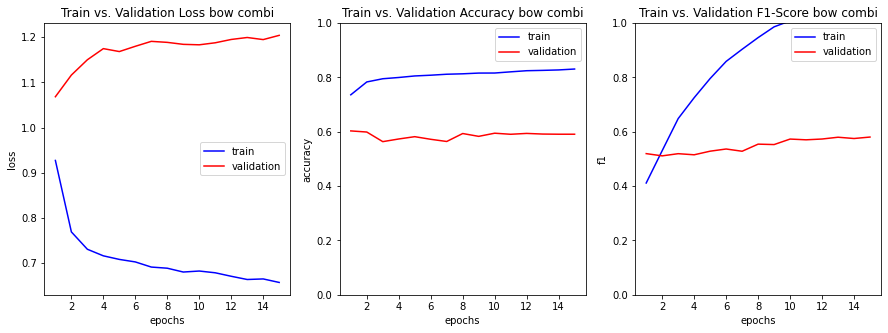

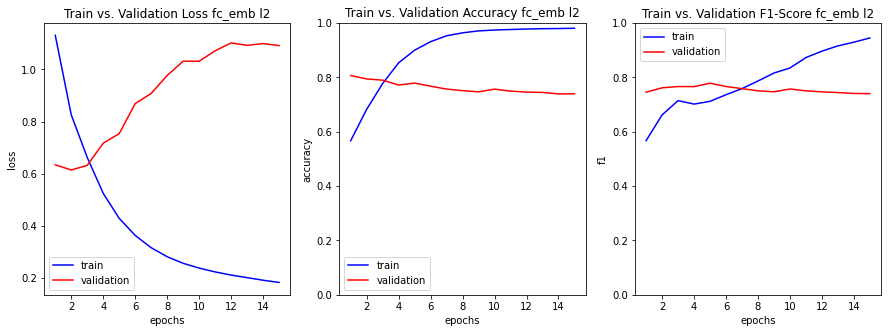

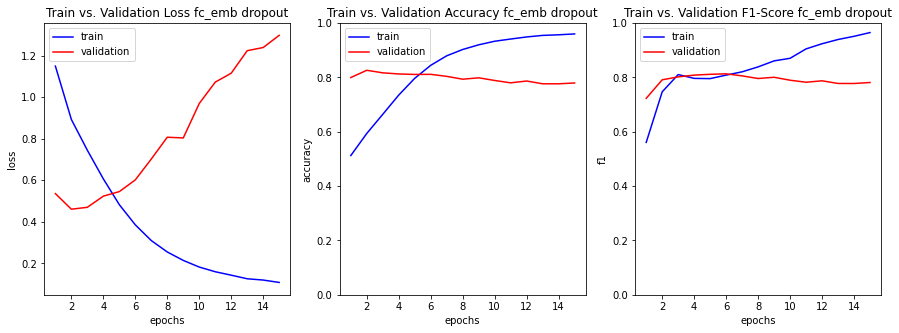

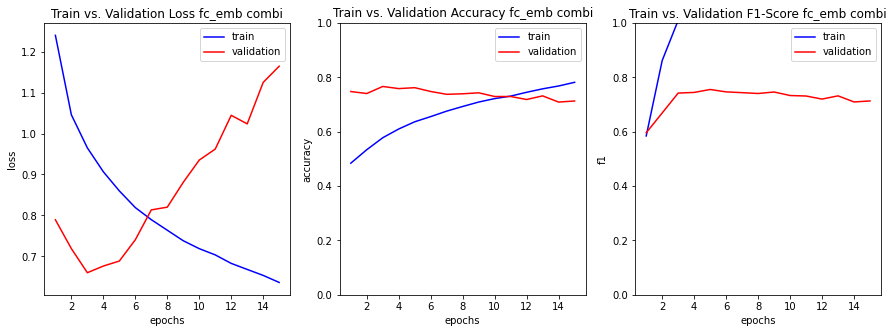

In [51]:
for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        fig = plt.figure(figsize=(15, 5))
        ax = plt.subplot(131)

        epochs = PARAMS['epochs']
        epochs_graph = range(1, PARAMS['epochs'] + 1)
        folds = PARAMS['k']

        mask = (history_all_df_reg.loc[:, 'model_type'] == model_type) & (
            history_all_df_reg.loc[:, 'reg_mode'] == reg_mode)

        loss_all = history_all_df_reg.loc[mask, 'loss'].to_list()
        loss_prep = [loss_all[i * epochs:(i + 1) * epochs]
                     for i in range(folds)]
        loss = [np.mean([x[i] for x in loss_prep]) for i in range(epochs)]

        val_loss_all = history_all_df_reg.loc[mask, 'val_loss'].to_list()
        val_loss_prep = [
            val_loss_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
        val_loss = [np.mean([x[i] for x in val_loss_prep])
                    for i in range(epochs)]

        accuracy_all = history_all_df_reg.loc[mask, 'accuracy'].to_list()
        accuracy_prep = [
            accuracy_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
        accuracy = [np.mean([x[i] for x in accuracy_prep])
                    for i in range(epochs)]

        val_accuracy_all = history_all_df_reg.loc[mask, 'val_accuracy'].to_list(
        )
        val_accuracy_prep = [val_accuracy_all[i *
                                              epochs:(i + 1) * epochs] for i in range(folds)]
        val_accuracy = [np.mean([x[i] for x in val_accuracy_prep])
                        for i in range(epochs)]

        f1_all = history_all_df_reg.loc[mask, 'f1'].to_list()
        f1_prep = [f1_all[i * epochs:(i + 1) * epochs] for i in range(folds)]
        f1 = [np.mean([x[i] for x in f1_prep]) for i in range(epochs)]

        val_f1_all = history_all_df_reg.loc[mask, 'val_f1'].to_list()
        val_f1_prep = [val_f1_all[i * epochs:(i + 1) * epochs]
                       for i in range(folds)]
        val_f1 = [np.mean([x[i] for x in val_f1_prep]) for i in range(epochs)]

        plt.plot(epochs_graph, loss, 'b')
        plt.plot(epochs_graph, val_loss, 'r')
        plt.ylim([0, 2])
        ax.set_ylabel('loss')
        ax.set_xlabel('epochs')
        ax.legend(['train', 'validation'])
        plt.title(f'Train vs. Validation Loss {model_type} {reg_mode}')

        ax = plt.subplot(132)
        plt.plot(epochs_graph, accuracy, 'b')
        plt.plot(epochs_graph, val_accuracy, 'r')
        plt.ylim([0, 1])
        ax.set_ylabel('accuracy')
        ax.set_xlabel('epochs')
        ax.legend(['train', 'validation'])
        plt.title(f'Train vs. Validation Accuracy {model_type} {reg_mode}')

        ax = plt.subplot(133)
        plt.plot(epochs_graph, f1, 'b')
        plt.plot(epochs_graph, val_f1, 'r')
        plt.ylim([0, 1])
        ax.set_ylabel('f1')
        ax.set_xlabel('epochs')
        ax.legend(['train', 'validation'])
        plt.title(f'Train vs. Validation F1-Score {model_type} {reg_mode}')

        if logging:
            if not os.path.exists(os.path.join(logdir, 'figures')):
                os.makedirs(os.path.join(logdir, 'figures'))
            fig.savefig(os.path.join(
                logdir, f'figures/loss_accuracy_training_{model_type}_{reg_mode}.png'), bbox_inches='tight')

In [66]:
def compare_models_by_metric(model_type, reg_mode, history_all_df, history_all_df_reg, metric, params):
    '''
    Function to compare a metric between two models 

    Args:
        model_type - model used
        reg_mode - regularisation mode used - l2, dropout, combination of the two
        history_all_df - dataframe with results from models without regularisation
        history_all_df_reg - dataframe with results from models with regularisation
        metric - metric to compare
        params - parameters dictionary

    Returns:
        plot of metrics of models
    '''

    epochs = PARAMS['epochs']
    epochs_graph = range(1, PARAMS['epochs'] + 1)
    folds = PARAMS['k']

    mask_base = (history_all_df.loc[:, 'model_type'] == model_type)
    mask_reg = (history_all_df_reg.loc[:, 'model_type'] == model_type) & (
        history_all_df_reg.loc[:, 'reg_mode'] == reg_mode)

    metric_all_base = history_all_df.loc[mask_base, metric].to_list()
    metric_prep_base = [
        metric_all_base[i * epochs:(i + 1) * epochs] for i in range(folds)]
    metric_base = [np.mean([x[i] for x in metric_prep_base])
                   for i in range(epochs)]

    metric_all_reg = history_all_df_reg.loc[mask_reg, metric].to_list()
    metric_prep_reg = [
        metric_all_reg[i * epochs:(i + 1) * epochs] for i in range(folds)]
    metric_reg = [np.mean([x[i] for x in metric_prep_reg]) for i in range(epochs)]

    metrics_dict = {
        'loss': 'Training Loss',
        'acc': 'Training Accuracy',
        'precision': 'Training Precision',
        'recall': 'Training Recall',
        'f1': 'Training F1',
        'val_loss': 'Validation Loss',
        'val_acc': 'Validation Accuracy',
        'val_precision': 'Validation Precision',
        'val_recall': 'Validation Recall',
        'val_f1': 'Validation F1'
    }

    metric_label = metrics_dict[metric]
    plt.plot(epochs_graph, metric_base, 'bo', label=f'{model_type} No Regularisation')
    plt.plot(epochs_graph, metric_reg, 'b',
             label=f'{model_type} {reg_mode} Regularisation')
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

    if logging:
        if not os.path.exists(os.path.join(logdir, 'figures')):
            os.makedirs(os.path.join(logdir, 'figures'))
            fig.savefig(os.path.join(
                logdir, f'figures/compare_base_vs_regularised_model_{model_type}_{reg_mode}.png'), bbox_inches='tight')

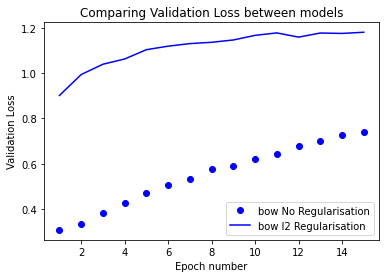

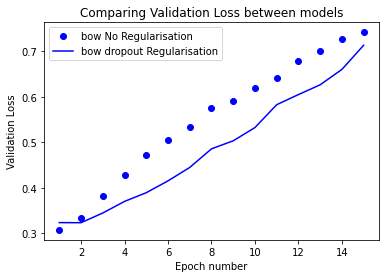

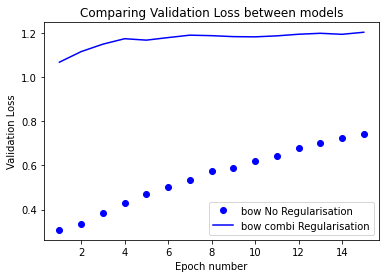

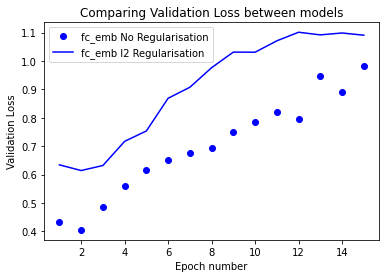

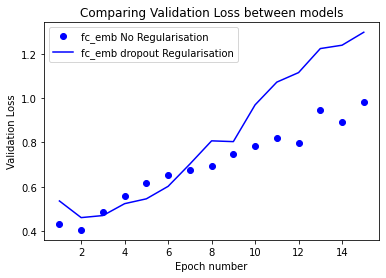

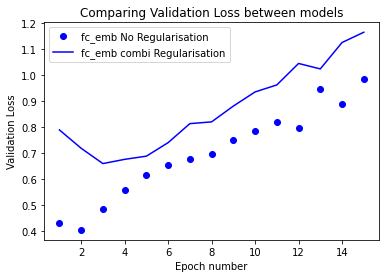

In [67]:
for model_type in ['bow', 'fc_emb']:
    for reg_mode in PARAMS['reg_mode']:
        compare_models_by_metric(model_type, reg_mode, history_all_df, history_all_df_reg, 'val_loss', PARAMS)

In [71]:
def optimal_epoch(history_df, model_type):
    """
    Function to return the epoch number where the validation loss is
    at its minimum

    Args:
        history_df - dataframe with training & validation history of model
    Returns:
        epoch number with minimum validation loss
    """
    mask = history_df.loc[:, 'model_type'] == model_type
    min_epoch = np.argmin(history_df.loc[mask, 'val_loss']) + 1
    print(f'Minimum validation loss for {model_type} reached in epoch {min_epoch}')
    
    return min_epoch

In [72]:
for model_type in PARAMS['model_type']:
    optimal_epoch(history_all_df, model_type)

Minimum validation loss for bow reached in epoch 46
Minimum validation loss for fc_emb reached in epoch 48
Minimum validation loss for fc_transf reached in epoch 50
Minimum validation loss for lstm reached in epoch 47
Minimum validation loss for lstm_transf reached in epoch 49
Minimum validation loss for conv1d reached in epoch 32
Minimum validation loss for conv1d_transf reached in epoch 47


In [74]:
history_all_df[history_all_df['model_type']=='bow']

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,model_type,f1,val_f1
0,0.702180,0.738980,0.875577,0.506790,0.889611,0.629717,0.649603,0.578616,bow,0.641991,0.612058
1,0.246158,0.905499,0.910535,0.899488,0.970661,0.639151,0.652068,0.632075,bow,0.904978,0.641916
2,0.159991,0.939225,0.941150,0.938112,1.115557,0.629717,0.637530,0.625000,bow,0.939629,0.631203
3,0.121288,0.952248,0.952853,0.951581,1.265974,0.617138,0.619730,0.612421,bow,0.952217,0.616054
4,0.096759,0.962934,0.963140,0.962712,1.373973,0.639151,0.640985,0.634434,bow,0.962926,0.637693
5,0.086124,0.967164,0.967376,0.967053,1.451703,0.625000,0.628165,0.624214,bow,0.967214,0.626183
6,0.077659,0.969501,0.969812,0.969056,1.543741,0.636792,0.639331,0.631289,bow,0.969434,0.635285
7,0.072149,0.971505,0.971505,0.971505,1.658373,0.628145,0.629249,0.625786,bow,0.971505,0.627513
8,0.065267,0.973063,0.973172,0.973063,1.713950,0.635220,0.635499,0.630503,bow,0.973117,0.632991
9,0.058467,0.976180,0.976180,0.976180,1.766139,0.625786,0.626877,0.623428,bow,0.976180,0.625148
